In [1]:
# import packages
from astropy.io import fits
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from lmfit import Model, fit_report
from lmfit.models import LinearModel

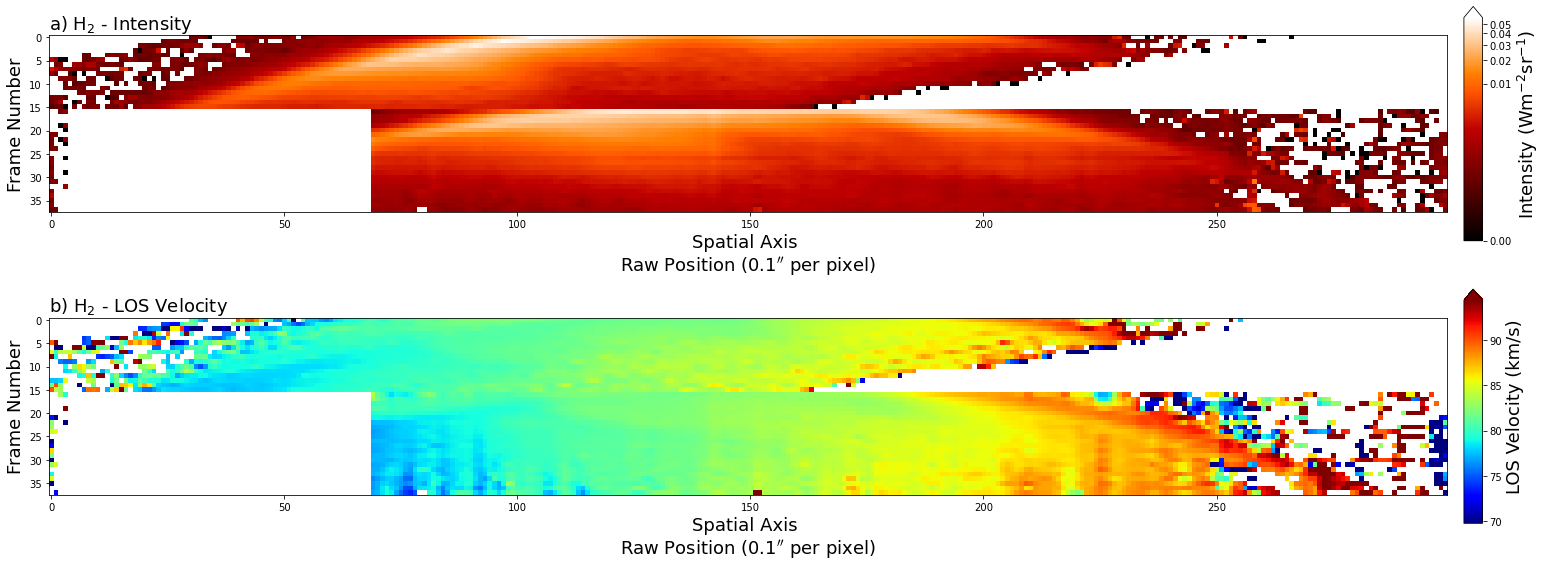

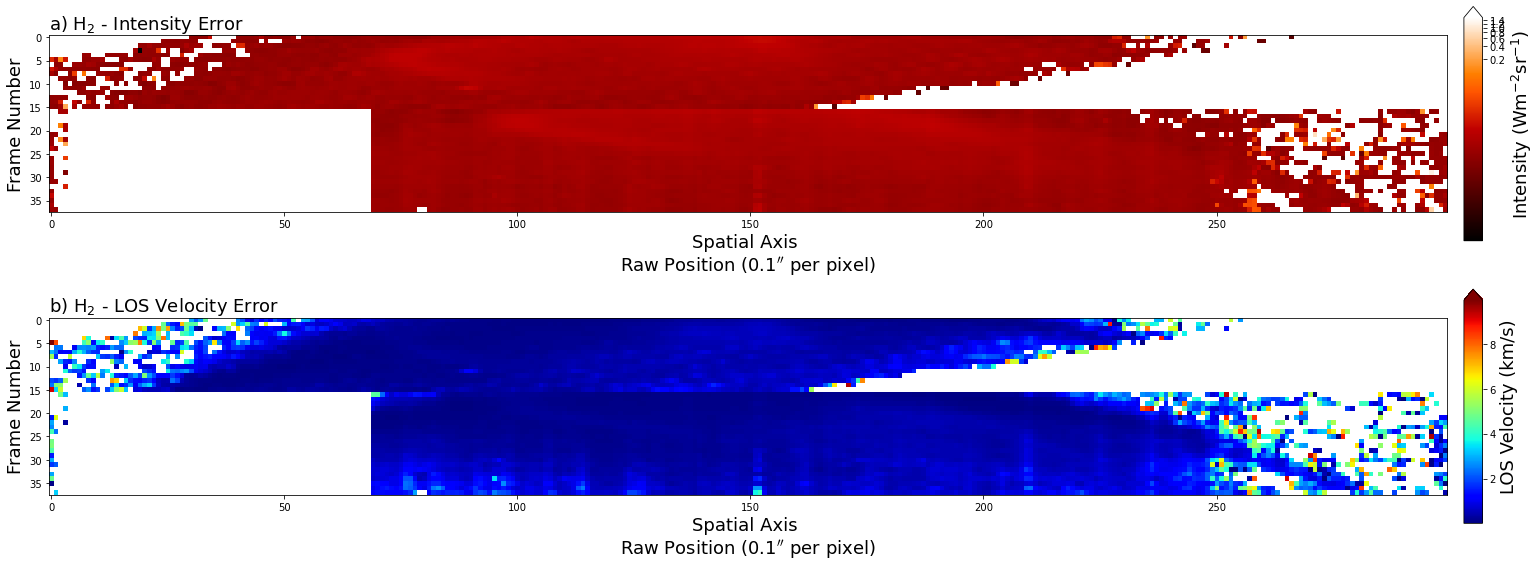

In [2]:
h2_int_shifted = fits.open('h2_int_shifted.fits', ignore_missing_end=True)[0].data
h2_los_shifted = fits.open('h2_los_shifted.fits', ignore_missing_end=True)[0].data
h2_int_shifted_error = fits.open('h2_int_shifted_error.fits', ignore_missing_end=True)[0].data
h2_los_shifted_error = fits.open('h2_los_shifted_error.fits', ignore_missing_end=True)[0].data

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h2_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

0.11981140339526057


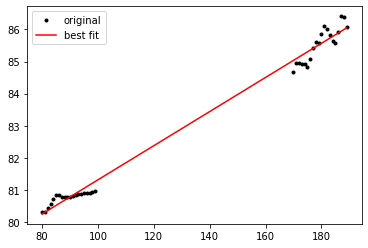

In [3]:
# subtract velocity at center of planet
# top half [:16]
crop1a = np.delete(h2_los_shifted[3:6], np.s_[100:], axis=1)
crop1b = np.delete(crop1a, np.s_[:80], axis=1)
crop2a = np.delete(h2_los_shifted[7:10], np.s_[190:], axis=1)
crop2b = np.delete(crop2a, np.s_[:170], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(crop1b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

# plt.figure(figsize=(10,5))
# plt.imshow(crop2b, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_crop1b = np.mean(crop1b, axis=0)
avg_crop2b = np.mean(crop2b, axis=0)
line1 = np.linspace(80,99,20)
line2 = np.linspace(170,189,20)

line_tot = np.concatenate((line1,line2))
avg_crop_tot = np.concatenate((avg_crop1b, avg_crop2b))

# best fit line
mod = LinearModel()

pars_crop = mod.guess(avg_crop_tot, x=line_tot)
out_crop = mod.fit(avg_crop_tot, pars_crop, x=line_tot)

# print(out.fit_report(min_correl=0.25))

m = out_crop.params['slope'].value
y0 = out_crop.params['intercept'].value
sig_m = out_crop.params['slope'].stderr
sig_y0 = out_crop.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
x_fit = np.linspace(80,189,110)
avg_crop_best_fit = m * x_fit + y0
avg_crop_error = np.sqrt(sig_m**2 + sig_y0**2)
print(avg_crop_error)

plt.figure()
plt.plot(line_tot, avg_crop_tot,'.k', label = 'original')
plt.plot(x_fit, avg_crop_best_fit, 'r', label = 'best fit')
plt.legend()

0.15589215558030464


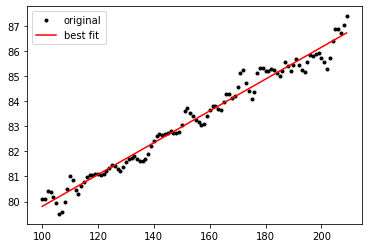

In [4]:
# bottom half [16:]
box1a = np.delete(h2_los_shifted[30:35], np.s_[210:], axis=1)
box2a = np.delete(box1a, np.s_[:100], axis=1)

# plt.figure(figsize=(10,5))
# plt.imshow(box, cmap='jet', norm=colors.PowerNorm(gamma=0.2))

avg_box = np.mean(box2a, axis=0)

x_axis = np.linspace(100,209,110)

mod = LinearModel()

pars_box = mod.guess(avg_box, x=x_axis)
out_box = mod.fit(avg_box, pars_box, x=x_axis)

# print(out.fit_report(min_correl=0.25))

k = out_box.params['slope'].value
b = out_box.params['intercept'].value
sig_k = out_box.params['slope'].stderr
sig_b = out_box.params['intercept'].stderr

avg_box_best_fit = k * x_axis + b
avg_box_error = np.sqrt(sig_k**2 + sig_b**2)
print(avg_box_error)

plt.figure()
plt.plot(x_axis, avg_box,'.k', label = 'original')
# np.savetxt('h2_box.txt', avg_box)
plt.plot(x_axis, avg_box_best_fit, 'r', label = 'best fit')
plt.legend()

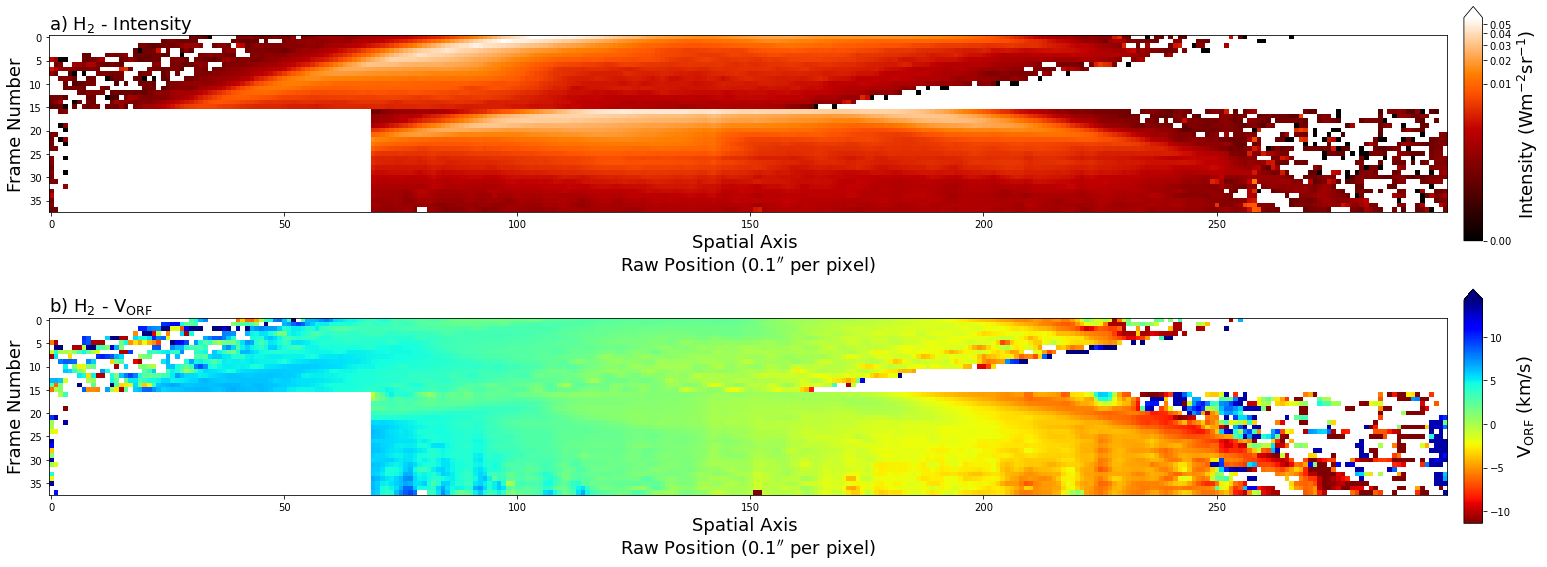

In [5]:
h2_los_shifted_sec1 = np.delete(h2_los_shifted, np.s_[16:], axis=0)
h2_los_shifted_sec2 = np.delete(h2_los_shifted, np.s_[:16], axis=0)

h2_los_rel_sec1 = h2_los_shifted_sec1 - avg_crop_best_fit[np.where(x_fit==150)][0]
h2_los_rel_sec2 = h2_los_shifted_sec2 - avg_box_best_fit[np.where(x_axis==150)][0]

h2_los_rel = np.vstack((h2_los_rel_sec1, h2_los_rel_sec2))

# h2_int_shifted[np.isnan(h2_int_shifted_error)] = np.nan
# h2_los_rel[np.isnan(h2_los_shifted_error)] = np.nan
# h2_los_rel[h2_los_rel>=6] = 6
# h2_los_rel[h2_los_rel<=-6] = -6


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(212)
plt.imshow(h2_los_rel*(-1), cmap='jet_r')
# plt.imshow(h2_los_rel, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - V$_{\mathrm{ORF}}$', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{ORF}}$ (km/s)',size=18)

7.601413890095622


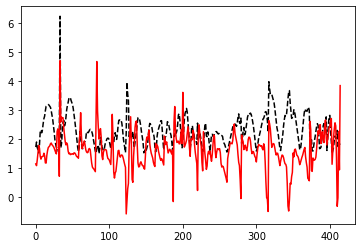

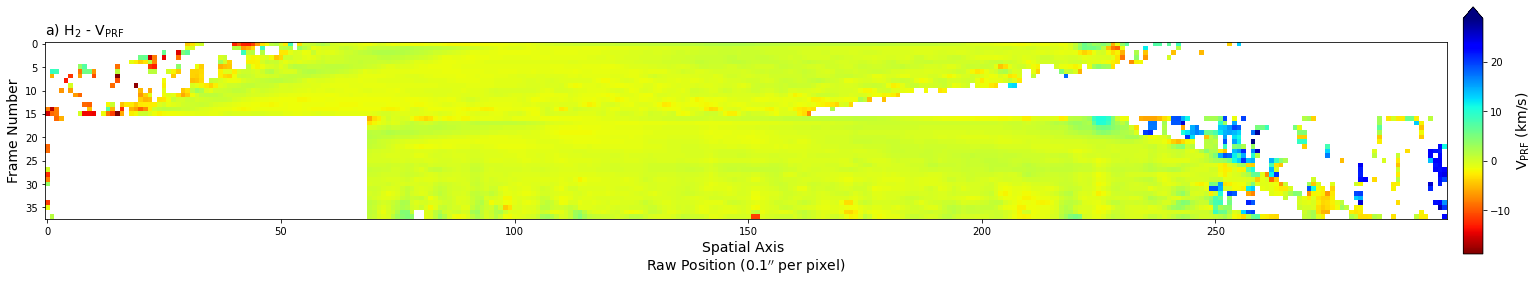

In [6]:
ang_diam = 40.58867
ang_diam/(0.1)
limb_vel = 12.572
vel_slope = limb_vel * 2 / (ang_diam/(0.1))

x = np.linspace(0,299,300)
rot_rate = vel_slope * x
rot_rate = rot_rate - rot_rate[150]

h2_plan_vel = h2_los_rel + 0

for i in range(np.size(h2_los_rel, 0)):
    h2_plan_vel[i,:] = h2_los_rel[i,:] - rot_rate


spatial_velocity = h2_los_rel + 0
spatial_velocity[::] = 0

for i in range(np.size(spatial_velocity, 1)):
    for j in range(1, np.size(spatial_velocity, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            p = np.array((h2_int_shifted[j-1][i], h2_int_shifted[j][i], h2_int_shifted[j+1][i]))
#             print(j,i)
#             plt.figure()
#             plt.plot(y, p, 'k.', label='original')
            f = sp.interpolate.interp1d(y,p)
            xnew = np.linspace(0,2,7)
#             plt.figure()
#             plt.plot(xnew, f(xnew), 'r.', label='interpolate')
#             plt.legend()
#             print(f(xnew[2]), f(xnew[4]))
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di = (p3 - p1)/(p3 + p1)
            dv = 10*di
            
            if np.isreal(dv):
                spatial_velocity[j,i] = dv
                
spatial_velocity2 = spatial_velocity + 0
spatial_velocity2[np.isnan(h2_int_shifted_error)] = np.nan
spatial_velocity2[spatial_velocity <= 1.5] = np.nan

h2_plan_vel2 = h2_plan_vel + 0
h2_plan_vel2[h2_plan_vel2 < -1] = np.nan
h2_plan_vel2[h2_plan_vel2 > 5] = np.nan
h2_plan_vel2[h2_los_shifted_error > 1] = np.nan
h2_plan_vel2[np.isnan(spatial_velocity2)] = np.nan

spatial_velocity2[np.isnan(h2_plan_vel2)] = np.nan

a = spatial_velocity2[np.isfinite(spatial_velocity2)]
b = h2_plan_vel2[np.isfinite(h2_plan_vel2)]

print(10/(np.mean(a[60:220])/np.mean(b[60:220])))

# spatial_velocity.shape
plt.figure()
plt.plot(a, 'k--')
plt.plot(b, 'r-')

h2_corrected_vel = h2_plan_vel - spatial_velocity
# h2_corrected_vel[h2_corrected_vel > 2] = 2
# h2_corrected_vel[h2_corrected_vel < -2] = -2

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h2_corrected_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_2$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

In [13]:
x = a[60:220]
y = b[60:220]
z = (np.mean(x)/np.mean(y))
z

1.3155447321490614

In [17]:
z * np.sqrt((np.std(x)/np.mean(x))**2 + (np.std(x)/np.mean(x))**2)

0.3504589627160336